In [96]:
import sys
sys.path.insert(0, '../../../frxas.py')
sys.path.insert(0, '../')
import glob
import itertools

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from frxas import hdf5_io
from frxas import models
from frxas import visualization
from frxas.models import save_fit_report, load_fit_report

import analyze_comsol as an_com

%reload_ext autoreload
%autoreload 2

In [2]:
file_dir = r"D:/COMSOL/PatternedFilm_Potentiodynamic/2D/Table Exports/Xv Profiles/" 

G_str = r'G-2_14'
f = r'10pt-dec'
pO2 = ''#r'pO2-0_01'

Xv = r'Re'
all_files = an_com.get_all_files(file_dir, G_str, f, Xv)
all_files.sort(key=an_com.sort_by_pO2)
all_files

['D:/COMSOL/PatternedFilm_Potentiodynamic/2D/Table Exports/Xv Profiles\\G-2_14_f-[1e-3,1e6]_10pt-dec_MB_pO2-0_01_Xv-Re.csv',
 'D:/COMSOL/PatternedFilm_Potentiodynamic/2D/Table Exports/Xv Profiles\\G-2_14_f-[1e-3,1e6]_10pt-dec_MB_pO2-0_1_Xv-Re.csv',
 'D:/COMSOL/PatternedFilm_Potentiodynamic/2D/Table Exports/Xv Profiles\\G-2_14_f-[1e-3,1e6]_10pt-dec_MB_pO2-1_Xv-Re.csv']

In [3]:
%%time
dfs = []
for file in all_files:
    if "RCMask" not in file:
        dat = an_com.extract_Xv(file, f_start=-3, f_stop=6, L=1)
        dat.x = dat.x
        dfs.append(dat)

Wall time: 4.07 s


In [97]:
starts = [[4, 199, 2, 3], [6, 149, 6, 0], [2, 99, 3]] # [[0,0,0,0],[0,0,0,0],[0,0,0]]
f1 = hdf5_io.get_all_datasets('..\Model Fitting\July18_20201211_processed', harmonic=1, start_indices=starts)

x, data1, ir_avgs, frequencies, gases, sizes = hdf5_io.unpack_data(f1, kind='adj')
ac_x = []
ac_x.append(x[1:4])
ac_x.append(x[5:8])
ac_x.append(x[9:])
ac_x = list(itertools.chain.from_iterable(a for a in ac_x))

In [27]:
dc_out = models.load_fit_report(r'../Fit Reports/20201211_processed_DC_data_UsedInThesis.txt')
ac_out = models.load_fit_report(r'../Fit Reports/ld_from_DC_FreeAmp_F3_pinned_UsedInThesis.txt')
ac_colors = ['r', 'b', 'c'] * 3

In [117]:
# Old style options
ac_colors = ['r', 'b', 'c'] * 3
ac_markers = ['s', '^', 'o'] * 3

aspect_ratio = 16 / 9 
figsize = (2.28 * 2.5, 3.25)#  (5, 5 / aspect_ratio ) #
leg_title_fontsize = 8
textsize = 8
borderpad = .2
borderaxespad = .25
columnspacing = .1
handletextpad = .1

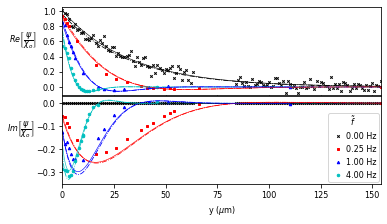

In [119]:
# 1% O2
merged = dfs[0].copy()

fig, axes = plt.subplots(nrows=2, figsize=figsize)

ao = 2.689
phi0 = 3.5781
fs = ['f=0', 'f=2.512e-01', 'f=1.000e+00', 'f=3.981e+00']
com_scale = phi0 / ao #np.abs(merged['f=0'].values[0])
amps = [5.3325e-2, 1.303e-2, 1.458e-2, 1.679e-2]
base = 2.7356e-3
dat_start = 0
dat_end = 4
ac_start = 0
ac_end = 3
DC_ind = 0

labels = [f'{0:.2f} Hz']
[labels.append(f'{ac_out.params[f"f_{i+1}"].value:.2f} Hz')
          for i in np.arange(ac_start, ac_end)]

an_com.plot_com_dataXv(merged,
                       x[dat_start:dat_end],
                       data1[dat_start:dat_end],
                       axes,
                       fs,                       
                       amps,
                       com_scale=com_scale,
                       base=base,
                       ms=2.5,
                       lw=.8,
                       labels=labels)

y = np.linspace(0, x[dat_start][-1], num=300)
visualization.plot_chi(axes,
                       y,
                       (models.dataset_fun(dc_out.params, DC_ind, y, an_com.chi_dc) - base) / amps[0],
                       color='k',
                       marker='',
                       ls='-',
                       lw=0.6,
                       fontsize=textsize) 

for iy in np.arange(ac_start, ac_end):
    f_norm = -1 / ac_out.params[f'amp_{iy+1}']
    y = np.linspace(0, ac_x[iy][-1], num=300)
    visualization.plot_chi(axes,
                           y,
                           models.dataset_fun(ac_out.params, iy, y, models.chi_patterned) * f_norm,
                           color=ac_colors[iy],
                           marker='',
                           ls='-',
                           lw=0.6,
                           fontsize=textsize)

for ax in axes:
    ax.set_xlim(0, x[dat_start+1][-1])
    ax.tick_params(axis='both', which='major', labelsize=textsize)
    ax.grid(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25))


axes[0].set_ylim(-.1, 1.05)
axes[1].set_ylim(-.35, .03)

# axes[0].set_ylabel(r'$Re\left[\dfrac{\psi}{\chi_o}\right]$')
axes[1].set_xlabel('y ($\mu$m)')
axes[0].set_ylabel(r'$Re\left[\dfrac{\psi}{\chi_o}\right]$', rotation=0, labelpad=20)
axes[1].set_ylabel(r'$Im\left[\dfrac{\psi}{\chi_o}\right]$', rotation=0, labelpad=15)
# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(title=r'$\tilde{f}$',
           title_fontsize=leg_title_fontsize,
           fontsize=textsize,
           borderpad=borderpad,
           borderaxespad=borderaxespad,
           columnspacing=columnspacing,
           handletextpad=handletextpad)

plt.savefig(r'../frXAS_2nd_Paper/Plots/Profiles/COMSOL_1%O2_8.svg', bbox_inches='tight')
plt.show()

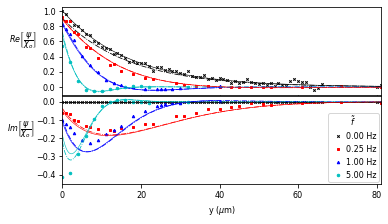

In [120]:
# 10% O2
merged = dfs[1].copy()

fig, axes = plt.subplots(nrows=2, figsize=figsize)

ao = 2.008
phi0 = 3.5781
fs = ['f=0', 'f=2.512e-01', 'f=1.000e+00', 'f=5.012e+00']
com_scale = phi0 / ao #np.abs(merged['f=0'].values[0])
amps = [4.0084e-2, 1.192e-2, 1.111e-2, 1.005e-2]
base = 1.3929e-3
dat_start = 4
dat_end = 8
ac_start = 3
ac_end = 6
DC_ind = 1


labels = [f'{0:.2f} Hz']
[labels.append(f'{ac_out.params[f"f_{i+1}"].value:.2f} Hz')
          for i in np.arange(ac_start, ac_end)]

an_com.plot_com_dataXv(merged,
                       x[dat_start:dat_end],
                       data1[dat_start:dat_end],
                       axes,
                       fs,                       
                       amps,
                       com_scale=com_scale,
                       base=base,
                       ms=2.5,
                       lw=.8,
                       labels=labels)

y = np.linspace(0, x[dat_start][-1], num=300)
visualization.plot_chi(axes,
                       y,
                       (models.dataset_fun(dc_out.params, DC_ind, y, an_com.chi_dc) - base) / amps[0],
                       color='k',
                       marker='',
                       ls='-',
                       lw=0.6,
                       fontsize=textsize) 

for iy in np.arange(ac_start, ac_end):
    f_norm = -1 / ac_out.params[f'amp_{iy+1}']
    y = np.linspace(0, ac_x[iy][-1], num=300)
    visualization.plot_chi(axes,
                           y,
                           models.dataset_fun(ac_out.params, iy, y, models.chi_patterned) * f_norm,
                           color=ac_colors[iy],
                           marker='',
                           ls='-',
                           lw=0.6,
                           fontsize=textsize)

for ax in axes:
    ax.set_xlim(0, x[dat_start+1][-1])
    ax.tick_params(axis='both', which='major', labelsize=textsize)
    ax.grid(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))


axes[0].set_ylim(-.1, 1.05)
axes[1].set_ylim(-.45, .03)

# axes[0].set_ylabel(r'$Re\left[\dfrac{\psi}{\chi_o}\right]$')
axes[1].set_xlabel('y ($\mu$m)')
axes[0].set_ylabel(r'$Re\left[\dfrac{\psi}{\chi_o}\right]$', rotation=0, labelpad=20)
axes[1].set_ylabel(r'$Im\left[\dfrac{\psi}{\chi_o}\right]$', rotation=0, labelpad=15)
# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(title=r'$\tilde{f}$',
           title_fontsize=leg_title_fontsize,
           fontsize=textsize,
           borderpad=borderpad,
           borderaxespad=borderaxespad,
           columnspacing=columnspacing,
           handletextpad=handletextpad)

plt.savefig(r'../frXAS_2nd_Paper/Plots/Profiles/COMSOL_10%O2_2.svg', bbox_inches='tight')
plt.show()

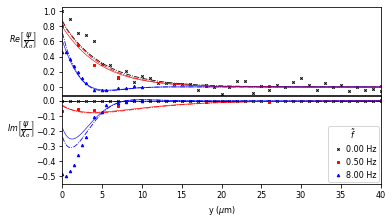

In [124]:
# 100% O2
merged = dfs[2].copy()

fig, axes = plt.subplots(nrows=2, figsize=figsize)

ao = 1.673
phi0 = 3.5781
fs = ['f=0', 'f=5.012e-01', 'f=7.943e+00']
com_scale = phi0 / ao
amps = [2.445e-2, 7.1406e-3, 7.2756e-3]
base = 6.819e-6
dat_start = 8
dat_end = 12
ac_start = 6
ac_end = 8
DC_ind = 2


labels = [f'{0:.2f} Hz']
[labels.append(f'{ac_out.params[f"f_{i+1}"].value:.2f} Hz')
          for i in np.arange(ac_start, ac_end)]

an_com.plot_com_dataXv(merged,
                       x[dat_start:dat_end],
                       data1[dat_start:dat_end],
                       axes,
                       fs,                       
                       amps,
                       com_scale=com_scale,
                       base=base,
                       ms=2.5,
                       lw=.8,
                       labels=labels)

y = np.linspace(0, x[dat_start][-1], num=300)
visualization.plot_chi(axes,
                       y,
                       (models.dataset_fun(dc_out.params, DC_ind, y, an_com.chi_dc) - base) / amps[0],
                       color='k',
                       marker='',
                       ls='-',
                       lw=0.6,
                       fontsize=textsize) 

for iy in np.arange(ac_start, ac_end):
    f_norm = -1 / ac_out.params[f'amp_{iy+1}']
    y = np.linspace(0, ac_x[iy][-1], num=300)
    visualization.plot_chi(axes,
                           y,
                           models.dataset_fun(ac_out.params, iy, y, models.chi_patterned) * f_norm,
                           color=ac_colors[iy],
                           marker='',
                           ls='-',
                           lw=0.6,
                           fontsize=textsize)

for ax in axes:
    ax.set_xlim(0, x[dat_start+1][-1])
    ax.tick_params(axis='both', which='major', labelsize=textsize)
    ax.grid(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))


axes[0].set_ylim(-.1, 1.05)
axes[1].set_ylim(-.55, .03)

# axes[0].set_ylabel(r'$Re\left[\dfrac{\psi}{\chi_o}\right]$')
axes[1].set_xlabel('y ($\mu$m)')
axes[0].set_ylabel(r'$Re\left[\dfrac{\psi}{\chi_o}\right]$', rotation=0, labelpad=20)
axes[1].set_ylabel(r'$Im\left[\dfrac{\psi}{\chi_o}\right]$', rotation=0, labelpad=15)
# axes[0].set_title('1% $O_2$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
plt.legend(title=r'$\tilde{f}$',
           title_fontsize=leg_title_fontsize,
           fontsize=textsize,
           borderpad=borderpad,
           borderaxespad=borderaxespad,
           columnspacing=columnspacing,
           handletextpad=handletextpad)

plt.savefig(r'../frXAS_2nd_Paper/Plots/Profiles/COMSOL_100%O2_2.svg', bbox_inches='tight')
plt.show()

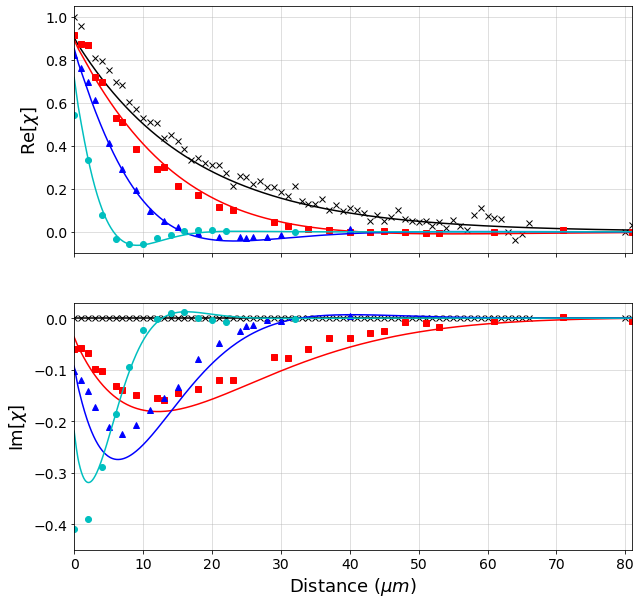

In [15]:
merged = dfs[1].copy()

_, axes = plt.subplots(nrows=2, figsize=(10, 10))

ao = 2.008
phi0 = 3.5781
fs = ['f=0', 'f=2.512e-01', 'f=1.000e+00', 'f=5.012e+00']
com_scale = phi0 / ao #np.abs(merged['f=0'].values[0])
amps = [4.0084e-2, 1.192e-2, 1.111e-2, 1.005e-2]
base = 1.3929e-3
dat_start = 4
dat_end = 8

an_com.plot_com_dataXv(merged, x[dat_start:dat_end], data1[dat_start:dat_end], axes, fs,
                       amps, com_scale=com_scale, base=base)

for ax in axes:
    ax.set_xlim(0, x[dat_start+1][-1])
axes[0].set_ylim(-.1, 1.05)
axes[1].set_ylim(-.45, .03)
plt.show()

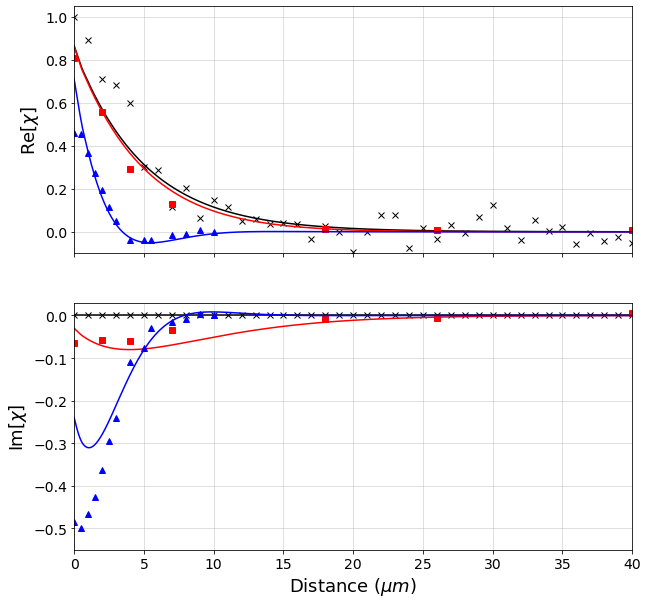

In [16]:
merged = dfs[2].copy()

_, axes = plt.subplots(nrows=2, figsize=(10, 10))

ao = 1.673
phi0 = 3.5781
fs = ['f=0', 'f=5.012e-01', 'f=7.943e+00']
com_scale = phi0 / ao
# com_scale = np.abs(merged['f=0'].values[0])
amps = [2.445e-2, 7.1406e-3, 7.2756e-3]
base = 6.819e-6
dat_start = 8
dat_end = 12

an_com.plot_com_dataXv(merged, x[dat_start:dat_end], data1[dat_start:dat_end], axes, fs,
                       amps, com_scale=com_scale, base=base, G=2.14)

for ax in axes:
    ax.set_xlim(0, x[dat_start+1][-1])
    
axes[0].set_ylim(-.1, 1.05)
axes[1].set_ylim(-.55, .03)
plt.show()

In [70]:
from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist

In [89]:
circ_str1 = 'R0-p(R1,CPE1)'
inits1 = [10, 47.2, 9.41e-3, .935]

circ1 = CustomCircuit(circuit=circ_str1, initial_guess=inits1)
f_sim = np.logspace(-3,6,num=91)

circ_str2 = 'R0-p(R1,C1)'
cpe1 = 7.63e-6*450/1.327*.11/280
inits2 = [10, 47.2, 1.801e-2]

circ2 = CustomCircuit(circuit=circ_str2, initial_guess=inits2)
f_sim = np.logspace(-3,6,num=91)

In [81]:
cpe1

1.016484551620196e-06

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
(32.622685459877914-21.285399813314047j) 0.3981071705534973
(32.10027840578012-23.552299996812003j) 0.19952623149688808


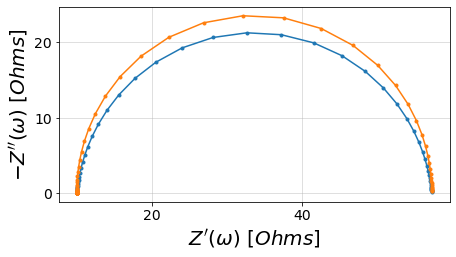

In [90]:
_, ax = plt.subplots(figsize=(7,10))
Z1_sim = circ1.predict(f_sim)
Z2_sim = circ2.predict(f_sim)

fp1 = np.argmin(Z1_sim.imag)
fp2 = np.argmin(Z2_sim.imag)

print(Z1_sim[fp1], f_sim[fp1])
print(Z2_sim[fp2], f_sim[fp2])

plot_nyquist(ax, Z1_sim)
plot_nyquist(ax, Z2_sim)